In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def convert_to_mb(bytes):
    return bytes / (1024.0 * 1024.0)

In [3]:
def callculate_data(df):
    df['corrected_alloc'] = (df['allocated'] - df['correction']).apply(convert_to_mb)
    df['correction'] = df['correction'].apply(convert_to_mb)
    df['allocated'] = df['allocated'].apply(convert_to_mb)
    df['resident'] = df['resident'].apply(convert_to_mb)
    return df

In [4]:
def plot_memory(df, label):
    df = df.sort_values(by=['id'])
    plt.plot(df['id'], df['corrected_alloc'], '.', label=label)


In [5]:
def make_plot_mem(x, y , log = False):
    df_naive = pd.read_csv(f"../results/naive_{x}_{y}.tsv", sep="\t")
    df_rc = pd.read_csv(f"../results/rc_{x}_{y}.tsv", sep="\t")
    df_rc_plus = pd.read_csv(f"../results/rc+_{x}_{y}.tsv", sep="\t")
    
    df_naive = callculate_data(df_naive)
    df_rc = callculate_data(df_rc)
    df_rc_plus = callculate_data(df_rc_plus)

    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.title(f"Allocated memory comparison between simulation types.\n Grid Size {x}x{y}")
    plt.xlabel("Iteration")
    plt.ylabel("Allocated Memory [MB]")
    if log:
        plt.yscale('log')
        plt.ylabel("Allocated Memory [MB] (Log scale)")
    plot_memory(df_naive, 'Naive')
    plot_memory(df_rc, 'Reference Counted')
    plot_memory(df_rc_plus, 'Reference Counted - Minimal Memory')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.show()

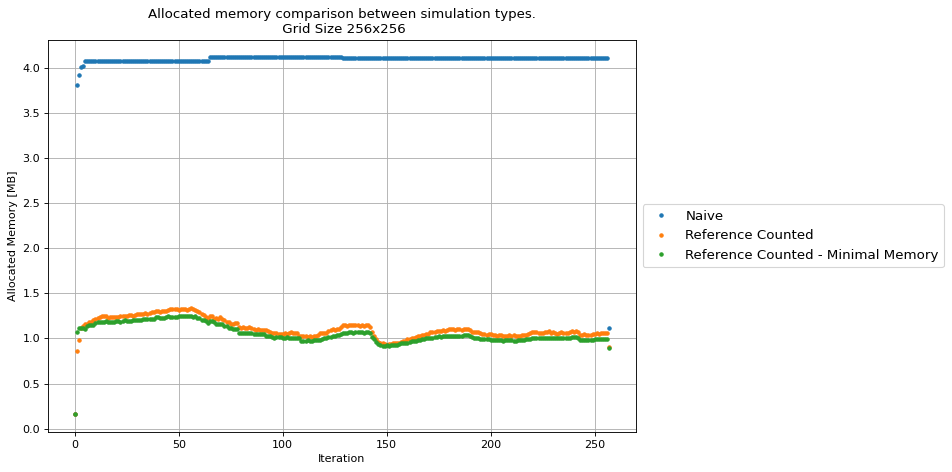

In [6]:
make_plot_mem(256,256)

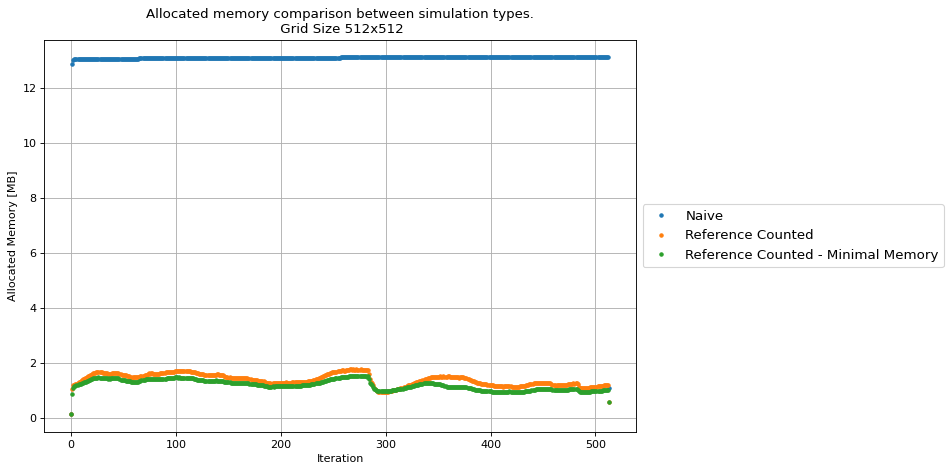

In [7]:
make_plot_mem(512,512)

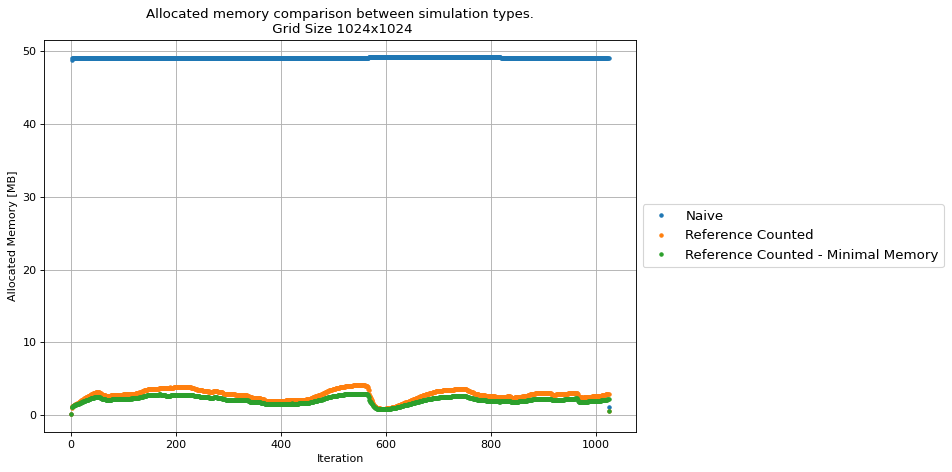

In [8]:
make_plot_mem(1024,1024)

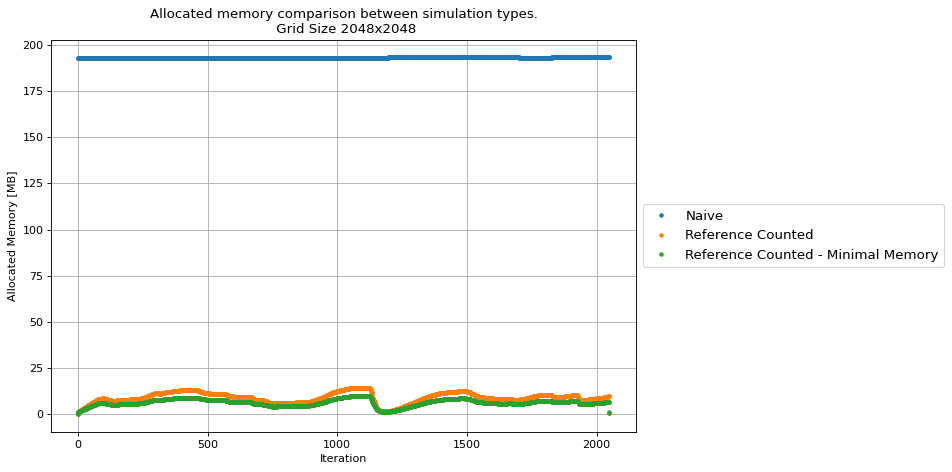

In [9]:
make_plot_mem(2048,2048)

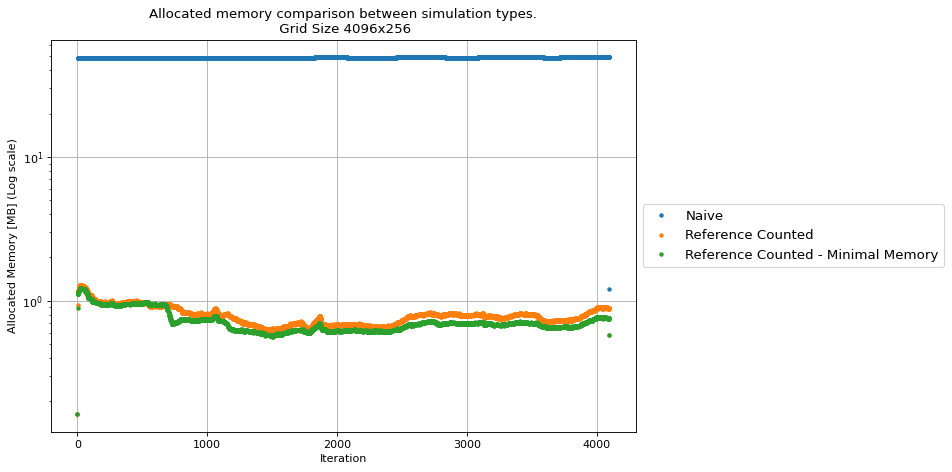

In [10]:
make_plot_mem(4096,256, log = True)

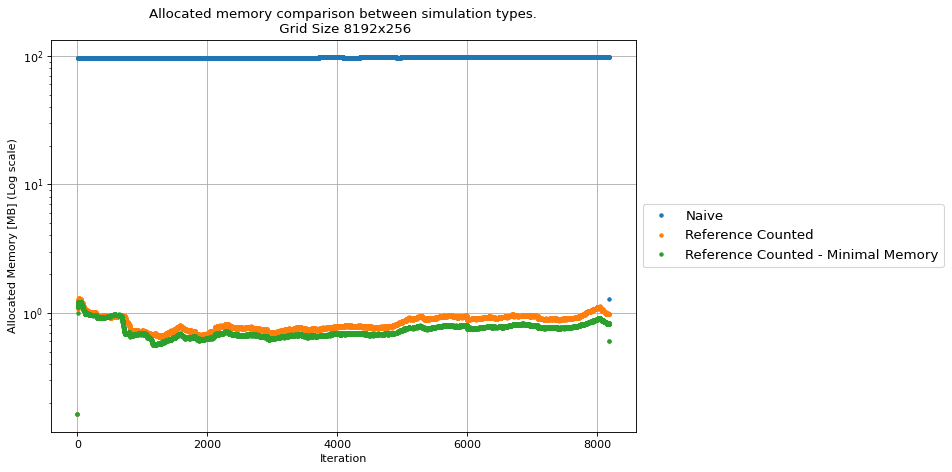

In [11]:
make_plot_mem(8192,256, log = True)

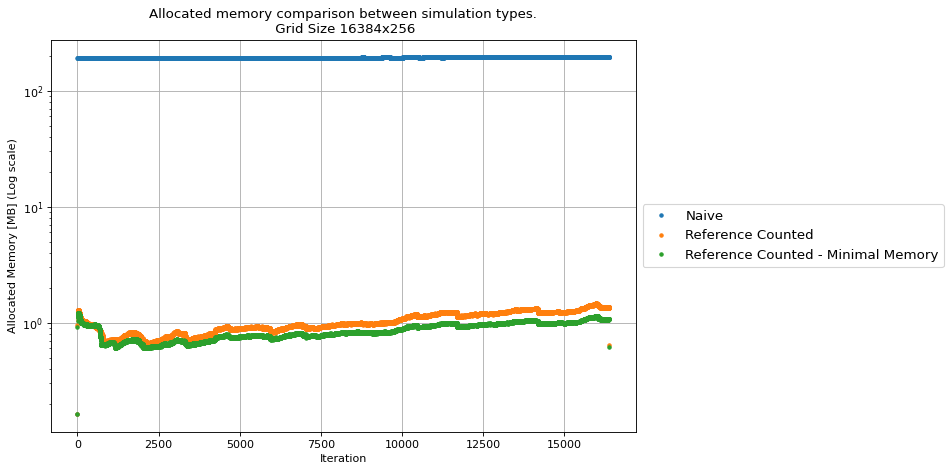

In [12]:
make_plot_mem(16384,256, log = True)

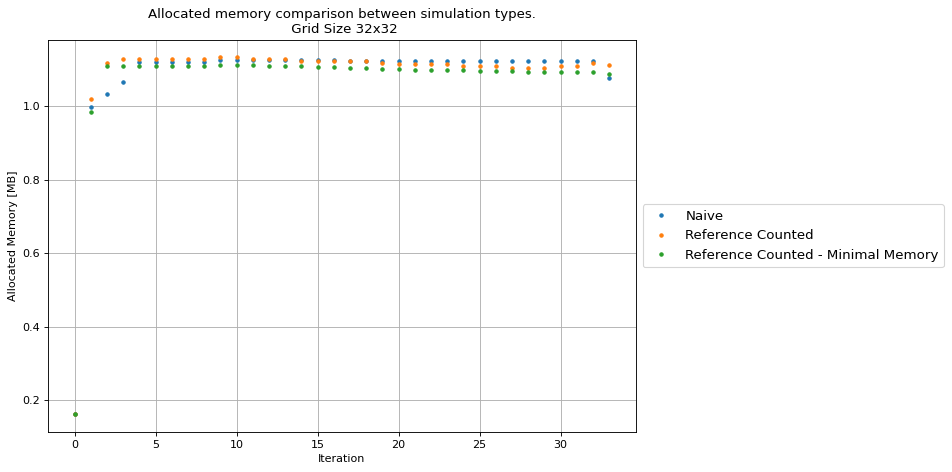

In [13]:
make_plot_mem(32,32)

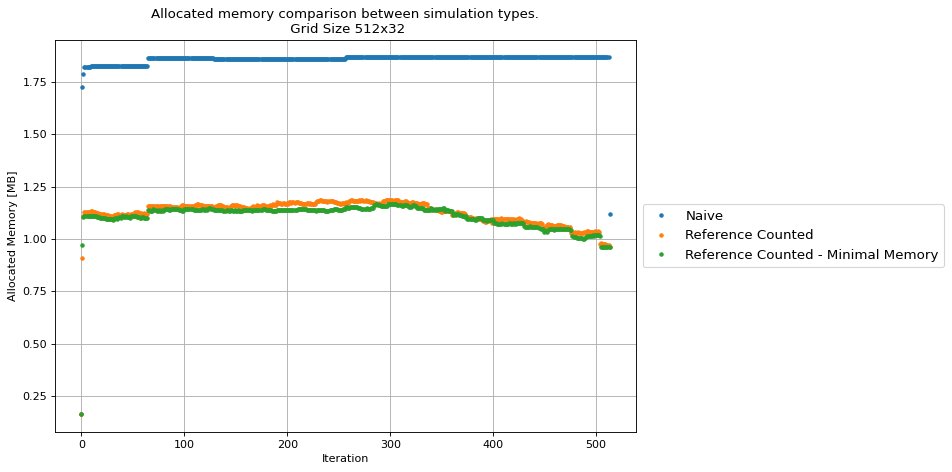

In [14]:
make_plot_mem(512,32)

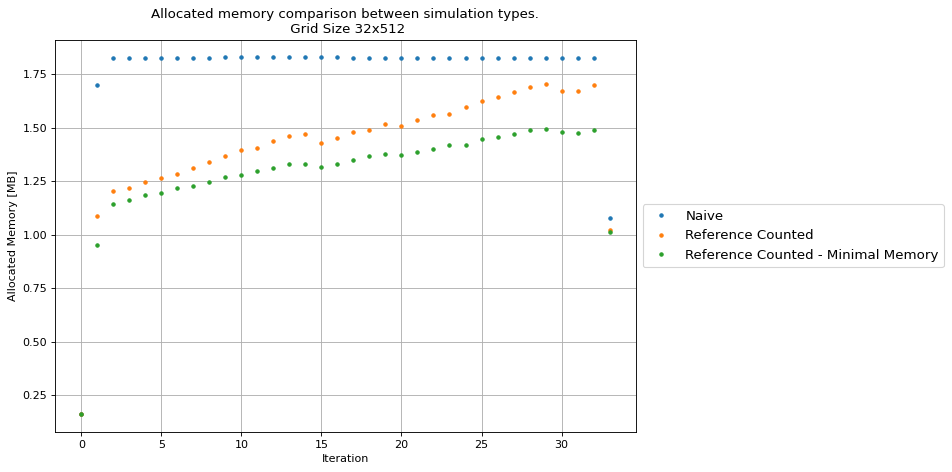

In [15]:
make_plot_mem(32,512)